In [33]:
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import tensorflow as tf

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors
from yad2k.utils.utils import preprocess_image

### Suppose for sake of argument that we were working on a self driving car.
### One very important aspect of this problem would be to identify and localize other cars, traffic lights, pedestrians etc. so as to determine where the "drivable" part of the image is.

### Succinctly:
- Given an image
- Is/are there objects in the image (e.g. car, pedestrian)
- Where are these objects (bounding boxes)?

### An example of the problem we are trying to solve is presented below

<img src="nb_images/box_label.png" width="800">

### The Model

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes. We will not be training this model, rather, using it to detect objects and establish bounding boxes.

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$. Here $p_c$ is a binary value denoting whether there is an object or not, $(b_x, b_y, b_w, b_h)$ are the bounding box dimensions and $c$ is a vector denoting which one of the objects is being represented (for the model we will be using the vector has length 80). If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers.

##### If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

The YOLO model segments the image into a 19x19 grid and feeds each of these segments through a series of convolutions and pooling layers, ending up with an output volume, in our case (19, 19, 85). A positive example looks something like $(1, 0.5, 0.5, 0.2, 0.3, 0, ..., 1, ..., 0)$, denoting that the midpoint of an object is present in that "cell" and a negative example would look like $(0, ?, ..., ?)$ - once we see a zero we do not care about the rest of the outputs.
<br/>
Much more can be said about the model, in particular with regard to the model architecture, anchor boxes and non max suppression, but this is not meant to be a lecture, we would like to see some results!

In [16]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=0.6):
    """
    filters YOLO boxes by thresholding on object and class confidence.

    arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold.
    for example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    box_scores = box_confidence * box_class_probs

    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)

    filtering_mask = (box_class_scores.numpy() > threshold)

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return scores, boxes, classes

In [17]:
def iou(box1, box2):
    """
    implement the intersection over union (IoU) between box1 and box2
    this will be used to determine which of the two bounding boxes is most likely to encapsulate the object we are looking for.

    arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)

    returns:
    iou score between the boxes
    """

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = xi2 - xi1 if xi2 > xi1 else 0
    inter_height = yi2 - yi1 if yi2 > yi1 else 0
    inter_area = inter_width * inter_height

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

In [18]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    applies non-max suppression (NMS) to set of boxes

    arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. note also that this
    function will transpose the shapes of scores, boxes, classes. this is made for convenience.
    """

    nms_indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_boxes,
        iou_threshold=0.5,
        name=None
    )
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    return scores, boxes, classes

In [19]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [20]:
def yolo_eval(yolo_outputs, image_shape=(720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=score_threshold)

    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=max_boxes,
                                                      iou_threshold=iou_threshold)

    return scores, boxes, classes

In [21]:
# define classes anchors and image shape

class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)  # same as yolo_model input layer size

In [22]:
# load a pre-trained model
yolo_model = load_model("model_data/", compile=False)

In [23]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [31]:
def predict(image_file):
    """
    runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    arguments:
    image_file -- name of an image stored in the "images" folder.
    
    returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes.
    """

    # preprocess your image
    image, image_data = preprocess_image("test_images/" + image_file, model_image_size=(608, 608))

    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1], image.size[0]], 10, 0.3, 0.5)

    # print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))

    # generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))

    # draw bounding boxes on the image file
    # draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)

    # save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)

    # display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    plt.figure(figsize=(12, 10))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg
car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


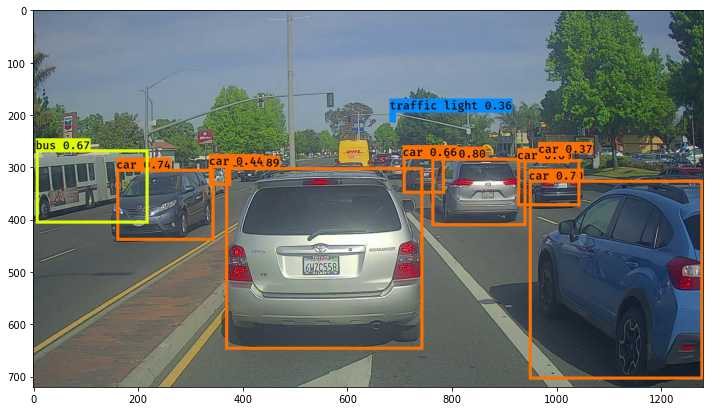

In [32]:
# run the model on an arbitrary image

out_scores, out_boxes, out_classes = predict("test.jpg")

### Summary

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes.
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- We then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output.

#### References

The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/)
- The structure of this notebook takes inspiration from the "Deep Learning Specialization" by Deeplearning.ai, specifically the section on CNN's.

### Car detection dataset

The sample dataset is provided by Drive.ai and is licensed under creative commons.